# ÊµÅÂèòÊÄßËÉΩÈ¢ÑÊµã - Âü∫‰∫éÁâ©ÁêÜ‰ø°ÊÅØÁ•ûÁªèÁΩëÁªúÔºàPINNÔºâ

Êú¨Á¨îËÆ∞Êú¨‰ΩøÁî®Áâ©ÁêÜ‰ø°ÊÅØÁ•ûÁªèÁΩëÁªúÔºàPhysics-Informed Neural Networks, PINNÔºâÊù•È¢ÑÊµãÈ´òÂàÜÂ≠êÊùêÊñôÁöÑÊµÅÂèòÊÄßËÉΩ„ÄÇÁõ∏ÊØî‰º†ÁªüÁöÑÊú∫Âô®Â≠¶‰π†ÊñπÊ≥ïÔºåPINNÂÖ∑Êúâ‰ª•‰∏ã‰ºòÂäøÔºö

1. ÁªìÂêàÁâ©ÁêÜÁ∫¶ÊùüÔºö
   - Cox-MerzËßÑÂàô
   - Kramers-KronigÂÖ≥Á≥ª
   - ÂÇ®ËÉΩÊçüËÄóËßíÁâ©ÁêÜÁ∫¶Êùü
   - ÁÉ≠ÂäõÂ≠¶Á∫¶Êùü

2. ÊîπËøõÁöÑÁâπÂæÅÂ∑•Á®ãÔºö
   - WLFÔºàWilliams-Landel-FerryÔºâÊó∂Ê∏©Á≠âÊïàÊÄß
   - ËÄÉËôëÂàÜÂ≠êÈáèÂíåÊ∏©Â∫¶ÁöÑËÄ¶ÂêàÊïàÂ∫î
   - ÈïøÂÆΩÊØîÁöÑÈùûÁ∫øÊÄßÊïàÂ∫î

3. ‰∏çÁ°ÆÂÆöÊÄßÈáèÂåñÔºö
   - ‰ΩøÁî®Ê∑±Â∫¶ÈõÜÊàêÂíåMonte Carlo Dropout
   - Êèê‰æõÈ¢ÑÊµãÁöÑÁΩÆ‰ø°Âå∫Èó¥

In [7]:
# ÂØºÂÖ•ÊâÄÈúÄÁöÑÂ∫ì
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import gamma
from typing import Tuple, List
from collections import defaultdict

# Ê£ÄÊü•CUDAÊòØÂê¶ÂèØÁî®
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"‰ΩøÁî®ËÆæÂ§á: {device}")

# ËÆæÁΩÆÈöèÊú∫ÁßçÂ≠ê‰ª•Á°Æ‰øùÂèØÈáçÂ§çÊÄß
RANDOM_SEED = 24
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(RANDOM_SEED)
    
# ËÆæÁΩÆÂÖ®Â±ÄÂèÇÊï∞
BATCH_SIZE = 64        # Â¢ûÂ§ßÊâπÊ¨°Â§ßÂ∞è
LEARNING_RATE = 8e-4   # Ë∞ÉÊï¥Â≠¶‰π†Áéá
EPOCHS = 1000          # Â¢ûÂä†ËÆ≠ÁªÉËΩÆÊï∞
PHYSICS_WEIGHT = 0.20  # Áâ©ÁêÜÁ∫¶ÊùüÊùÉÈáçÔºàÈôç‰ΩéÈÅøÂÖçËøáÂ∫¶Á∫¶ÊùüÔºâ
MC_SAMPLES = 200       # Monte CarloÈááÊ†∑Ê¨°Êï∞ÔºàÂ¢ûÂä†‰ª•Ëé∑ÂæóÊõ¥Á®≥ÂÆöÁöÑ‰∏çÁ°ÆÂÆöÊÄß‰º∞ËÆ°Ôºâ

‰ΩøÁî®ËÆæÂ§á: cpu


In [8]:
# Êï∞ÊçÆÂä†ËΩΩÂíåÈ¢ÑÂ§ÑÁêÜ
class RheologyDataset:
    def __init__(self, csv_path: str):
        """ÂàùÂßãÂåñÊï∞ÊçÆÈõÜÁ±ª
        
        Args:
            csv_path: PB_Data.csvÁöÑË∑ØÂæÑ
        """
        # ËØªÂèñÊï∞ÊçÆ
        self.df = pd.read_csv(csv_path)
        self.process_data()
        
    def process_data(self):
        """Êï∞ÊçÆÈ¢ÑÂ§ÑÁêÜÂíåÁâπÂæÅÂ∑•Á®ã"""
        df = self.df
        
        # ËÆ°ÁÆótan_deltaÂπ∂ËÆæÁΩÆÊùÉÈáç
        df['tan_delta'] = df['G2_Pa'] / df['G1_Pa']
        df['data_weight'] = 1.0
        mask_outlier = (df['tan_delta'] < 0) | (df['tan_delta'] > 10)
        df.loc[mask_outlier, 'data_weight'] = 0.0
        
        # Âü∫Êú¨ÁâπÂæÅÂ∑•Á®ã
        df['aspect_ratio'] = df['Length_nm'] / df['Width_nm']
        df['log_freq'] = np.log10(df['Freq_rad_s'])
        
        # ÂàÜÂ≠êÈáèÁõ∏ÂÖ≥ÁâπÂæÅ
        if 'Mw' in df.columns and 'Mn' in df.columns:
            df['PDI'] = df['Mw'] / df['Mn']  # ÂàÜÂ≠êÈáèÂàÜÂ∏ÉÊåáÊï∞
            df['log_Mw'] = np.log10(df['Mw'])
            df['log_Mn'] = np.log10(df['Mn'])
        else:
            # Â¶ÇÊûúÊ≤°ÊúâÂàÜÂ≠êÈáèÊï∞ÊçÆÔºåÊ∑ªÂä†Á©∫Âàó
            df['Mw'] = 0
            df['Mn'] = 0
            df['PDI'] = 1
            df['log_Mw'] = 0
            df['log_Mn'] = 0
        
        # ÊµìÂ∫¶ÁâπÂæÅÔºàÂ¶ÇÊûúÂ≠òÂú®Ôºâ
        if 'c' in df.columns:
            df['log_c'] = np.log10(df['c'])
        else:
            df['c'] = 0
            df['log_c'] = 0
        
        # WLFÊó∂Ê∏©Á≠âÊïàÊÄßÁâπÂæÅ
        T_ref = 25  # ÂèÇËÄÉÊ∏©Â∫¶
        C1 = 8.86   # WLFÂèÇÊï∞
        C2 = 101.6  # WLFÂèÇÊï∞
        df['aT'] = 10 ** (-C1 * (df['Temp_C'] - T_ref) / (C2 + df['Temp_C'] - T_ref))
        df['reduced_freq'] = df['Freq_rad_s'] * df['aT']
        
        # Ê∏©Â∫¶Áõ∏ÂÖ≥ÁâπÂæÅ
        df['temp_inv'] = 1 / (df['Temp_C'] + 273.15)  # ÂºÄÂ∞îÊñáÊ∏©Â∫¶ÁöÑÂÄíÊï∞
        df['T_x_aspect'] = df['Temp_C'] * df['aspect_ratio']
        
        # ÂØπÊï∞ËΩ¨Êç¢ÁõÆÊ†áÂèòÈáèÔºà‰ΩøÁî®ÂÆâÂÖ®ÁöÑÂØπÊï∞ËΩ¨Êç¢Ôºâ
        df['log_G1'] = np.log10(np.clip(df['G1_Pa'], 1e-10, None))
        df['log_G2'] = np.log10(np.clip(df['G2_Pa'], 1e-10, None))
        
        print("\nÊï∞ÊçÆÁªüËÆ°:")
        print("\nG1_PaËåÉÂõ¥:", df['G1_Pa'].min(), "-", df['G1_Pa'].max())
        print("G2_PaËåÉÂõ¥:", df['G2_Pa'].min(), "-", df['G2_Pa'].max())
        print("\nlog_G1ËåÉÂõ¥:", df['log_G1'].min(), "-", df['log_G1'].max())
        print("log_G2ËåÉÂõ¥:", df['log_G2'].min(), "-", df['log_G2'].max())
        
        # ÂÆö‰πâÁâπÂæÅÂàó
        self.feature_cols = [
            'Length_nm', 'Width_nm', 'aspect_ratio', 'Temp_C', 
            'log_freq', 'temp_inv', 'T_x_aspect', 'aT',
            'log_Mw', 'log_Mn', 'PDI', 'log_c' 
        ]
        self.target_cols = ['log_G1', 'log_G2']
        
        # Êï∞ÊçÆÊ†áÂáÜÂåñ
        self.scaler_X = StandardScaler()
        self.scaler_y = StandardScaler()
        
        # ÂáÜÂ§áËÆ≠ÁªÉÊï∞ÊçÆ
        X = self.scaler_X.fit_transform(df[self.feature_cols])
        y = self.scaler_y.fit_transform(df[self.target_cols])
        
        # ‰øùÂ≠òÊï∞ÊçÆÊùÉÈáç
        self.data_weights = torch.FloatTensor(df['data_weight'].values).to(device)
        
        # ÊâìÂç∞Ê†áÂáÜÂåñÂèÇÊï∞
        print("\nÁâπÂæÅÊ†áÂáÜÂåñÂèÇÊï∞:")
        for name, scale, mean in zip(self.feature_cols, self.scaler_X.scale_, self.scaler_X.mean_):
            print(f"{name}: scale={scale:.4f}, mean={mean:.4f}")
            
        print("\nÁõÆÊ†áÊ†áÂáÜÂåñÂèÇÊï∞:")
        for name, scale, mean in zip(self.target_cols, self.scaler_y.scale_, self.scaler_y.mean_):
            print(f"{name}: scale={scale:.4f}, mean={mean:.4f}")
        
        # ÂàÜÂâ≤Êï∞ÊçÆÈõÜ
        X_train, X_val, y_train, y_val = train_test_split(
            X, y, test_size=0.2, random_state=RANDOM_SEED, stratify=None
        )
        
        # Ëé∑ÂèñÁõ∏Â∫îÁöÑÊùÉÈáç
        train_indices = np.arange(len(df))[:-len(y_val)]
        val_indices = np.arange(len(df))[-len(y_val):]
        train_weights = self.data_weights[train_indices]
        val_weights = self.data_weights[val_indices]
        
        # ËΩ¨Êç¢‰∏∫PyTorchÂº†Èáè
        self.X_train = torch.FloatTensor(X_train).to(device)
        self.y_train = torch.FloatTensor(y_train).to(device)
        self.X_val = torch.FloatTensor(X_val).to(device)
        self.y_val = torch.FloatTensor(y_val).to(device)
        self.train_weights = train_weights
        self.val_weights = val_weights
        
        # ÂàõÂª∫Êï∞ÊçÆÂä†ËΩΩÂô®
        train_dataset = TensorDataset(self.X_train, self.y_train, self.train_weights)
        val_dataset = TensorDataset(self.X_val, self.y_val, self.val_weights)
        
        self.train_loader = DataLoader(
            train_dataset, batch_size=BATCH_SIZE, shuffle=True
        )
        self.val_loader = DataLoader(
            val_dataset, batch_size=BATCH_SIZE, shuffle=False
        )
        
    def inverse_transform_y(self, y_scaled):
        """Â∞ÜÊ†áÂáÜÂåñÁöÑÈ¢ÑÊµãÂÄºËΩ¨Êç¢ÂõûÂéüÂßãÂ∞∫Â∫¶"""
        if isinstance(y_scaled, torch.Tensor):
            y_scaled = y_scaled.cpu().detach().numpy()
        
        # È¶ñÂÖàÂèçÊ†áÂáÜÂåñÂà∞ÂØπÊï∞Á©∫Èó¥
        y_log = self.scaler_y.inverse_transform(y_scaled)
        
        # ÁÑ∂Âêé‰ªéÂØπÊï∞Á©∫Èó¥ËΩ¨Êç¢Âà∞ÂéüÂßãÁ©∫Èó¥
        return np.power(10.0, y_log)

# Âä†ËΩΩÊï∞ÊçÆ
dataset = RheologyDataset("PB_Data.csv")



Êï∞ÊçÆÁªüËÆ°:

G1_PaËåÉÂõ¥: 7.14e-07 - 785.8
G2_PaËåÉÂõ¥: 7.59e-06 - 186.69

log_G1ËåÉÂõ¥: -6.146301788223826 - 2.8953120244757873
log_G2ËåÉÂõ¥: -5.11975822410452 - 2.271121055704133

ÁâπÂæÅÊ†áÂáÜÂåñÂèÇÊï∞:
Length_nm: scale=97.3858, mean=111.0000
Width_nm: scale=4.6933, mean=25.4513
aspect_ratio: scale=4.7682, mean=4.8483
Temp_C: scale=7.0711, mean=25.0000
log_freq: scale=1.2018, mean=-0.0001
temp_inv: scale=0.0001, mean=0.0034
T_x_aspect: scale=128.5372, mean=121.2069
aT: scale=3.4040, mean=2.7386
log_Mw: scale=0.3265, mean=6.6789
log_Mn: scale=0.3087, mean=6.6896
PDI: scale=0.0813, mean=0.9797
log_c: scale=1.0000, mean=-1.2218

ÁõÆÊ†áÊ†áÂáÜÂåñÂèÇÊï∞:
log_G1: scale=2.0969, mean=0.5570
log_G2: scale=1.2305, mean=0.8273


In [9]:
class RheologyPINN(nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int = 256, dropout_rate: float = 0.05):
        """ÂàùÂßãÂåñPINNÊ®°Âûã"""
        super(RheologyPINN, self).__init__()
        
        # ÂÖ±‰∫´ÁºñÁ†ÅÂô®ÁΩëÁªúÔºàÊõ¥Ê∑±Â±ÇÊ¨°Ôºâ
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.GELU(),  # ‰ΩøÁî®GELUÊøÄÊ¥ªÂáΩÊï∞
            nn.Dropout(dropout_rate),
            
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout_rate),
            
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout_rate),
            
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout_rate)
        )
        
        # G'È¢ÑÊµãÂàÜÊîØÔºà‰∏ìÈó®ÁöÑÁªìÊûÑÔºâ
        self.g_prime_branch = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim//2),
            nn.BatchNorm1d(hidden_dim//2),
            nn.GELU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim//2, hidden_dim//4),
            nn.BatchNorm1d(hidden_dim//4),
            nn.GELU(),
            nn.Linear(hidden_dim//4, 1)
        )
        
        # G"È¢ÑÊµãÂàÜÊîØ
        self.g_double_prime_branch = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim//2),
            nn.BatchNorm1d(hidden_dim//2),
            nn.GELU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim//2, hidden_dim//4),
            nn.BatchNorm1d(hidden_dim//4),
            nn.GELU(),
            nn.Linear(hidden_dim//4, 1)
        )
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # ÈÄöËøáÁºñÁ†ÅÂô®
        encoded = self.encoder(x)
        
        # È¢ÑÊµãG'ÂíåG"
        g_prime = self.g_prime_branch(encoded)
        g_double_prime = self.g_double_prime_branch(encoded)
        
        return torch.cat([g_prime, g_double_prime], dim=1)
    
    def predict_with_uncertainty(self, x: torch.Tensor, mc_samples: int = 200) -> Tuple[torch.Tensor, torch.Tensor]:

        self.train()  # ÂêØÁî®dropout
        predictions = []
        
        with torch.no_grad():
            for _ in range(mc_samples):
                pred = self(x)
                predictions.append(pred)
                
        predictions = torch.stack(predictions)
        mean_pred = predictions.mean(dim=0)
        std_pred = predictions.std(dim=0, unbiased=True)  # ‰ΩøÁî®Êó†ÂÅèÊ†áÂáÜÂ∑Æ‰º∞ËÆ°
        
        return mean_pred, std_pred
    
    def physics_loss(self, x_batch: torch.Tensor, y_pred: torch.Tensor, dataset: RheologyDataset) -> Tuple[torch.Tensor, dict]:

        # Ëé∑ÂèñÈ¢ëÁéáÁõ∏ÂÖ≥ÂèÇÊï∞ÔºàÈÅøÂÖçnumpyËΩ¨Êç¢Ôºâ
        freq_idx = dataset.feature_cols.index('log_freq')
        log_freq = x_batch[:, freq_idx] * dataset.scaler_X.scale_[freq_idx] + dataset.scaler_X.mean_[freq_idx]
        freq = torch.pow(10.0, log_freq)
        
        # ÂèçÊ†áÂáÜÂåñÈ¢ÑÊµãÂÄºÔºà‰øùÊåÅÂú®ÂØπÊï∞Á©∫Èó¥Ôºâ
        y_std = torch.tensor(dataset.scaler_y.scale_).to(device)
        y_mean = torch.tensor(dataset.scaler_y.mean_).to(device)
        log_g_prime = y_pred[:, 0] * y_std[0] + y_mean[0]
        log_g_double_prime = y_pred[:, 1] * y_std[1] + y_mean[1]
        
        # ËΩ¨Êç¢Âà∞Á∫øÊÄßÁ©∫Èó¥
        g_prime = torch.pow(10.0, log_g_prime)
        g_double_prime = torch.pow(10.0, log_g_double_prime)
        
        # ===== Ê†∏ÂøÉÁ∫¶Êùü1: Cox-MerzËßÑÂàô =====
        # Á°Æ‰øùÂ§çÊï∞Á≤òÂ∫¶ÈöèÈ¢ëÁéáÂçïË∞ÉÈÄíÂáè
        log_complex_viscosity = torch.log10(torch.sqrt(g_prime**2 + g_double_prime**2) / freq + 1e-10)
        visc_diff = log_complex_viscosity[1:] - log_complex_viscosity[:-1]
        # Âú®‰ΩéÈ¢ëÂå∫ÂüüÂä†Âº∫Á∫¶ÊùüÔºå‰ΩøÁî®ËøûÁª≠ÁöÑÊùÉÈáçÂáΩÊï∞
        # ‰ΩøÁî® sigmoid ÂáΩÊï∞ÂÆûÁé∞Âπ≥ÊªëËøáÊ∏°Ôºö‰ªé‰ΩéÈ¢ë(ÊùÉÈáç~2.0)Âà∞È´òÈ¢ë(ÊùÉÈáç~1.0)
        # weight = 1 + 1/(1 + exp(k*(log10(freq) - threshold)))
        # ÂΩì log10(freq) = threshold Êó∂ÔºåÊùÉÈáç = 1.5Ôºà‰∏≠Èó¥ÂÄºÔºâ
        freq_weight = 1.0 + 1.0 / (1.0 + torch.exp(5.0 * (torch.log10(freq[1:]) - 0.0)))
        weighted_visc_diff = visc_diff * freq_weight
        cox_merz_loss = torch.mean(torch.relu(weighted_visc_diff))
        
        # ===== Ê†∏ÂøÉÁ∫¶Êùü2: tan(Œ¥)ËåÉÂõ¥Á∫¶Êùü =====
        # ÈôêÂà∂ÊçüËÄóËßíÊ≠£ÂàáÂÄºÂú®Áâ©ÁêÜÂêàÁêÜËåÉÂõ¥ÂÜÖ (0 < tan(Œ¥) < 10.0)
        loss_tangent = g_double_prime / (g_prime + 1e-10)
        angle_loss = torch.mean(torch.relu(-loss_tangent) + 
                              torch.relu(loss_tangent - 10.0))
        
        # ===== Ê†∏ÂøÉÁ∫¶Êùü3: ÊñúÁéáËåÉÂõ¥Á∫¶Êùü =====
        # ËÆ°ÁÆóG'ÂíåG"ÁöÑ‰∏ÄÈò∂ÂØºÊï∞ÔºàÂú®ÂØπÊï∞Á©∫Èó¥‰∏≠Ôºâ
        log_g_prime_grad = log_g_prime[1:] - log_g_prime[:-1]
        log_g_double_prime_grad = log_g_double_prime[1:] - log_g_double_prime[:-1]
        
        # ÈôêÂà∂ÊñúÁéáÂú®ÂêàÁêÜËåÉÂõ¥Ôºö-0.1 < slope < 0.4
        # ‰∏ãÁïåÂÖÅËÆ∏ËΩªÂæÆ‰∏ãÈôçÔºå‰∏äÁïåÈò≤Ê≠¢ÂèòÂåñËøáÂø´
        slope_range_loss = (torch.mean(torch.relu(-0.1 - log_g_prime_grad)) +  # Á°Æ‰øù >= -0.1
                          torch.mean(torch.relu(log_g_prime_grad - 0.4)) +  # Á°Æ‰øù <= 0.4
                          torch.mean(torch.relu(-0.1 - log_g_double_prime_grad)) + 
                          torch.mean(torch.relu(log_g_double_prime_grad - 0.4)))
        
        # ===== Ê†∏ÂøÉÁ∫¶Êùü4: Âπ≥ÊªëÊÄßÁ∫¶Êùü =====
        # ÈôêÂà∂‰∫åÈò∂ÂØºÊï∞ÔºåÈò≤Ê≠¢Êõ≤Á∫øÁ™ÅÂèòÂíåÈúáËç°
        g_prime_smoothness = torch.mean(torch.abs(log_g_prime_grad[1:] - log_g_prime_grad[:-1]))
        g_double_prime_smoothness = torch.mean(torch.abs(log_g_double_prime_grad[1:] - log_g_double_prime_grad[:-1]))
        smoothness_loss = g_prime_smoothness + g_double_prime_smoothness
        
        # ===== Ê†∏ÂøÉÁ∫¶Êùü5: ÁÉ≠ÂäõÂ≠¶Á∫¶Êùü =====
        # Á°Æ‰øùG' > 0 Âíå G" > 0ÔºàÁâ©ÁêÜÁ°¨Á∫¶ÊùüÔºâ
        thermo_loss = torch.mean(torch.relu(-log_g_prime) + torch.relu(-log_g_double_prime))
        
        # ÁªÑÂêàÊâÄÊúâÁâ©ÁêÜÊçüÂ§±ÔºàÁ≤æÁÆÄÂêéÁöÑÊùÉÈáçÂàÜÈÖçÔºâ
        loss_components = {
            'cox_merz': cox_merz_loss * 0.20,      # ÊµÅÂèòÂ≠¶Âü∫Êú¨ËßÑÂæã
            'angle': angle_loss * 0.50,            # Áâ©ÁêÜËåÉÂõ¥Á∫¶Êùü
            'slope_range': slope_range_loss * 0.40,  # ÊñúÁéá+ÂçïË∞ÉÊÄßÔºàÊúÄÈáçË¶ÅÔºâ
            'smoothness': smoothness_loss * 0.20,   # Êõ≤Á∫øÂπ≥ÊªëÊÄß
            'thermo': thermo_loss * 0.05            # Ê≠£ÂÄºÁ∫¶Êùü
        }
        
        total_physics_loss = sum(loss_components.values())
        
        return total_physics_loss, loss_components

# ÂàùÂßãÂåñÊ®°Âûã
model = RheologyPINN(input_dim=len(dataset.feature_cols)).to(device)



ÂºÄÂßãËÆ≠ÁªÉ...
Epoch [10/1000]
Train - Total: 0.7256, Physics: 1.4643
Physics Components:
  cox_merz: 0.2258
  angle: 0.1083
  slope_range: 0.5184
  smoothness: 0.6031
  thermo: 0.0087
Val   - Total: 0.6723, Physics: 1.2355
LR: 0.000034
Epoch [10/1000]
Train - Total: 0.7256, Physics: 1.4643
Physics Components:
  cox_merz: 0.2258
  angle: 0.1083
  slope_range: 0.5184
  smoothness: 0.6031
  thermo: 0.0087
Val   - Total: 0.6723, Physics: 1.2355
LR: 0.000034
Epoch [20/1000]
Train - Total: 0.7071, Physics: 1.5893
Physics Components:
  cox_merz: 0.2332
  angle: 0.1401
  slope_range: 0.5581
  smoothness: 0.6473
  thermo: 0.0106
Val   - Total: 0.6525, Physics: 1.3721
LR: 0.000040
Epoch [20/1000]
Train - Total: 0.7071, Physics: 1.5893
Physics Components:
  cox_merz: 0.2332
  angle: 0.1401
  slope_range: 0.5581
  smoothness: 0.6473
  thermo: 0.0106
Val   - Total: 0.6525, Physics: 1.3721
LR: 0.000040
Epoch [30/1000]
Train - Total: 0.6504, Physics: 1.4715
Physics Components:
  cox_merz: 0.2279
 

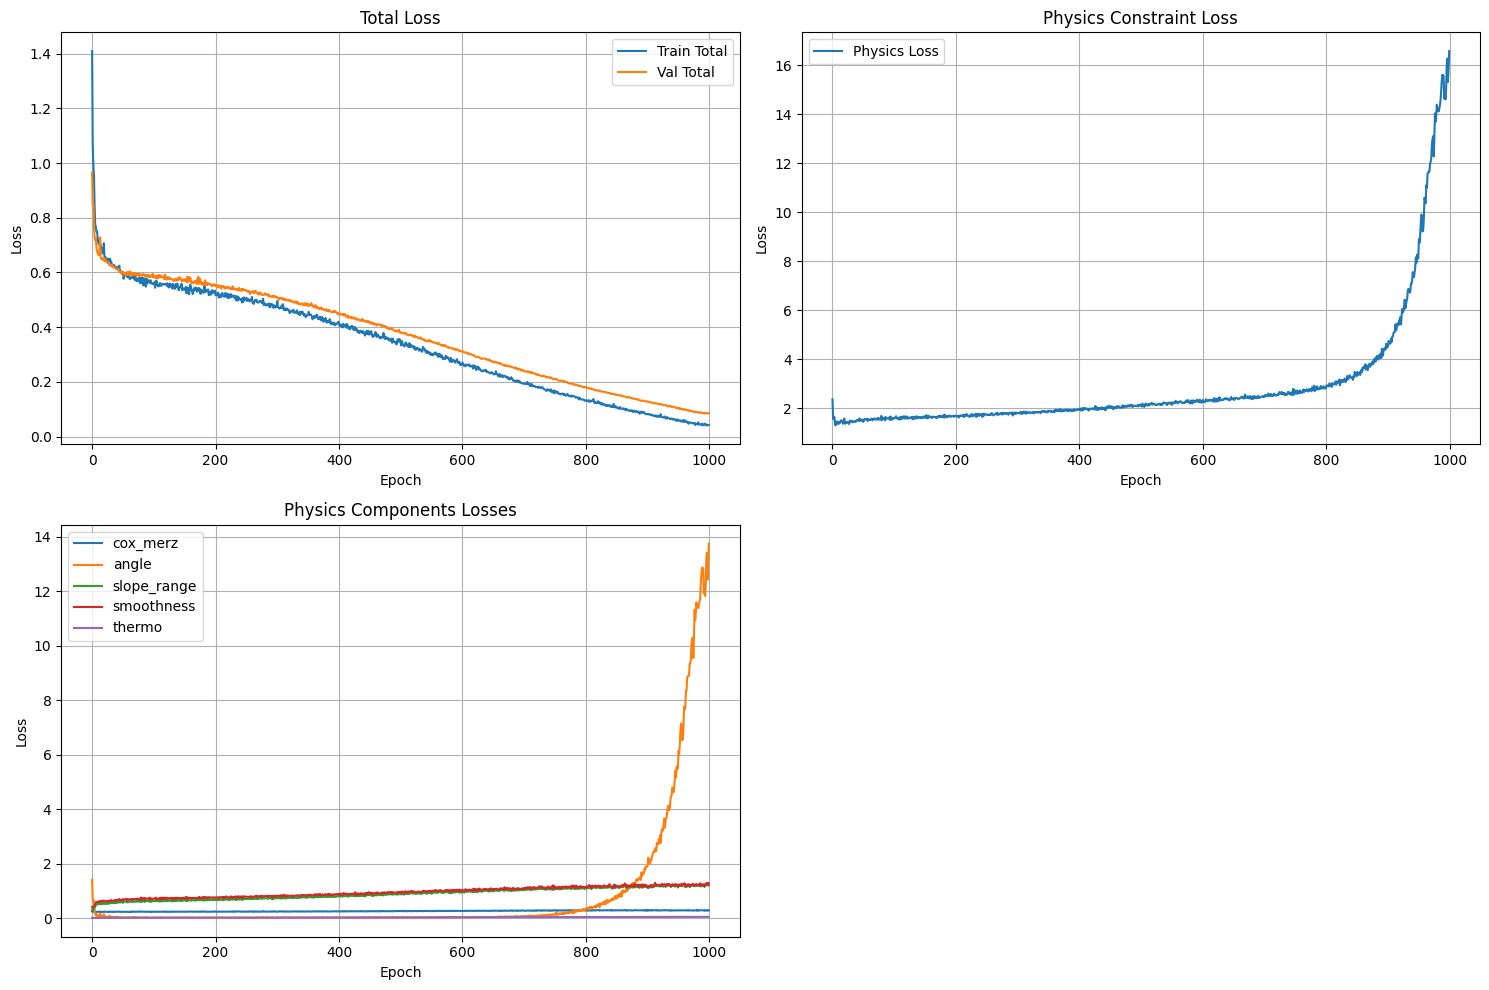

In [10]:
# ÂÆö‰πâËÆ≠ÁªÉÂáΩÊï∞
def train_model(model: RheologyPINN, 
                dataset: RheologyDataset,
                epochs: int,
                physics_weight: float) -> Tuple[List[float], List[float]]:
    """ËÆ≠ÁªÉPINNÊ®°Âûã
    
    Args:
        model: PINNÊ®°Âûã
        dataset: Êï∞ÊçÆÈõÜÂØπË±°
        epochs: ËÆ≠ÁªÉËΩÆÊï∞
        physics_weight: Áâ©ÁêÜÁ∫¶ÊùüÊçüÂ§±ÊùÉÈáç
        
    Returns:
        train_losses: ËÆ≠ÁªÉÊçüÂ§±ÂéÜÂè≤
        val_losses: È™åËØÅÊçüÂ§±ÂéÜÂè≤
    """
    # ‰ºòÂåñÂô®ËÆæÁΩÆ
    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LEARNING_RATE,
                                            epochs=epochs,
                                            steps_per_epoch=len(dataset.train_loader))
    
    # ÊçüÂ§±ÂáΩÊï∞
    mse_loss = nn.MSELoss(reduction='none')  # ‰ΩøÁî®'none'‰ª•ÊîØÊåÅÊ†∑Êú¨ÊùÉÈáç
    
    # ËÆ∞ÂΩïËÆ≠ÁªÉËøáÁ®ã
    train_losses = []
    val_losses = []
    train_physics_losses = []
    train_components_losses = defaultdict(list)
    best_val_loss = float('inf')
    best_model_state = None
    patience_counter = 0
    max_patience = 50
    
    print("\nÂºÄÂßãËÆ≠ÁªÉ...")
    for epoch in range(epochs):
        # ËÆ≠ÁªÉÈò∂ÊÆµ
        model.train()
        epoch_losses = []
        epoch_g_prime_losses = []
        epoch_g_double_prime_losses = []
        epoch_physics_losses = []
        epoch_components_losses = defaultdict(list)
        
        for batch_X, batch_y, batch_weights in dataset.train_loader:
            optimizer.zero_grad()
            
            # ÂâçÂêë‰º†Êí≠
            y_pred = model(batch_X)
            
            # ÂàÜÂà´ËÆ°ÁÆóG'ÂíåG"ÁöÑÊçüÂ§±ÔºàÂ∏¶ÊùÉÈáçÔºâ
            g_prime_losses = mse_loss(y_pred[:, 0], batch_y[:, 0])
            g_double_prime_losses = mse_loss(y_pred[:, 1], batch_y[:, 1])
            
            # Â∫îÁî®Ê†∑Êú¨ÊùÉÈáç
            g_prime_loss = (g_prime_losses * batch_weights).mean()
            g_double_prime_loss = (g_double_prime_losses * batch_weights).mean()
            
            # Êï∞ÊçÆÊçüÂ§±ÔºàÂä†ÊùÉÁªÑÂêàÔºâ
            data_loss = 0.6 * g_prime_loss + 0.4 * g_double_prime_loss
            
            # Áâ©ÁêÜÁ∫¶ÊùüÊçüÂ§±
            physics_loss, components_losses = model.physics_loss(batch_X, y_pred, dataset)
            
            # Âä®ÊÄÅÊùÉÈáçËÆ°ÁÆó
            current_step = epoch * len(dataset.train_loader) + len(epoch_losses)
            total_steps = epochs * len(dataset.train_loader)
            # ‰ΩøÁî®‰ΩôÂº¶ÈÄÄÁÅ´Ë∞ÉÊï¥Áâ©ÁêÜÁ∫¶ÊùüÊùÉÈáç
            physics_weight_dynamic = physics_weight * (
                1 + np.cos(np.pi * current_step / total_steps)
            ) / 2
            
            # ÊÄªÊçüÂ§±
            total_loss = data_loss + physics_weight_dynamic * physics_loss
            
            # ÂèçÂêë‰º†Êí≠
            total_loss.backward()
            
            # Ê¢ØÂ∫¶Ë£ÅÂâ™ÔºàÊåâËåÉÊï∞Ôºâ
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            scheduler.step()
            
            # ËÆ∞ÂΩïÊçüÂ§±
            epoch_losses.append(total_loss.item())
            epoch_g_prime_losses.append(g_prime_loss.item())
            epoch_g_double_prime_losses.append(g_double_prime_loss.item())
            epoch_physics_losses.append(physics_loss.item())
            
            # ËÆ∞ÂΩïÂêÑÁªÑÂàÜÊçüÂ§±
            for name, loss in components_losses.items():
                epoch_components_losses[name].append(loss.item())
        
        # ËÆ°ÁÆóÂπ≥ÂùáÊçüÂ§±
        avg_train_loss = np.mean(epoch_losses)
        avg_physics_loss = np.mean(epoch_physics_losses)
        avg_components_losses = {name: np.mean(losses) 
                               for name, losses in epoch_components_losses.items()}
        
        train_losses.append(avg_train_loss)
        train_physics_losses.append(avg_physics_loss)
        for name, avg_loss in avg_components_losses.items():
            train_components_losses[name].append(avg_loss)
        
        # È™åËØÅÈò∂ÊÆµ
        model.eval()
        val_epoch_losses = []
        val_physics_losses = []
        
        with torch.no_grad():
            for batch_X, batch_y, batch_weights in dataset.val_loader:
                y_pred = model(batch_X)
                
                # ËÆ°ÁÆóÂä†ÊùÉÈ™åËØÅÊçüÂ§±
                val_g_prime_losses = mse_loss(y_pred[:, 0], batch_y[:, 0])
                val_g_double_prime_losses = mse_loss(y_pred[:, 1], batch_y[:, 1])
                
                val_g_prime_loss = (val_g_prime_losses * batch_weights).mean()
                val_g_double_prime_loss = (val_g_double_prime_losses * batch_weights).mean()
                
                val_data_loss = 0.6 * val_g_prime_loss + 0.4 * val_g_double_prime_loss
                val_physics_loss, _ = model.physics_loss(batch_X, y_pred, dataset)
                
                val_total_loss = val_data_loss + physics_weight_dynamic * val_physics_loss
                val_epoch_losses.append(val_total_loss.item())
                val_physics_losses.append(val_physics_loss.item())
        
        avg_val_loss = np.mean(val_epoch_losses)
        avg_val_physics_loss = np.mean(val_physics_losses)
        val_losses.append(avg_val_loss)
        
        # ‰øùÂ≠òÊúÄ‰Ω≥Ê®°Âûã
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_state = model.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1
        
        # ÊèêÂâçÂÅúÊ≠¢Ê£ÄÊü•
        if patience_counter >= max_patience:
            print(f'\nÊèêÂâçÂÅúÊ≠¢! È™åËØÅÊçüÂ§±Âú®{max_patience}ËΩÆÂÜÖÊ≤°ÊúâÊîπÂñÑ.')
            break
        
        # ÊâìÂç∞ËÆ≠ÁªÉËøõÂ∫¶
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{epochs}]')
            print(f'Train - Total: {avg_train_loss:.4f}, Physics: {avg_physics_loss:.4f}')
            print('Physics Components:')
            for name, avg_loss in avg_components_losses.items():
                print(f'  {name}: {avg_loss:.4f}')
            print(f'Val   - Total: {avg_val_loss:.4f}, Physics: {avg_val_physics_loss:.4f}')
            print(f'LR: {scheduler.get_last_lr()[0]:.6f}')
    
    # Âä†ËΩΩÊúÄ‰Ω≥Ê®°Âûã
    model.load_state_dict(best_model_state)
    
    # ÁªòÂà∂ËØ¶ÁªÜÁöÑËÆ≠ÁªÉÂéÜÂè≤
    plt.figure(figsize=(15, 10))
    
    # ÊÄªÊçüÂ§±Êõ≤Á∫ø
    plt.subplot(2, 2, 1)
    plt.plot(train_losses, label='Train Total')
    plt.plot(val_losses, label='Val Total')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Total Loss')
    plt.legend()
    plt.grid(True)
    
    # Áâ©ÁêÜÁ∫¶ÊùüÊçüÂ§±Êõ≤Á∫ø
    plt.subplot(2, 2, 2)
    plt.plot(train_physics_losses, label='Physics Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Physics Constraint Loss')
    plt.legend()
    plt.grid(True)
    
    # ÂêÑÁªÑÂàÜÁâ©ÁêÜÁ∫¶ÊùüÊçüÂ§±
    plt.subplot(2, 2, 3)
    for name, losses in train_components_losses.items():
        plt.plot(losses, label=name)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Physics Components Losses')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    return train_losses, val_losses

# ËÆ≠ÁªÉÊ®°Âûã
train_losses, val_losses = train_model(model, dataset, EPOCHS, PHYSICS_WEIGHT)

‚ö†Ô∏è Ë≠¶ÂëäÔºöÈÉ®ÂàÜÈ¢ÑÊµãÂÄºË∂ÖÂá∫ÂêàÁêÜËåÉÂõ¥ÔºåÂ∑≤ËøõË°åË£ÅÂâ™

y_pred (Á∫øÊÄßÁ©∫Èó¥) ËåÉÂõ¥: [1.00e-03, 7.52e+02] Pa
y_true (Á∫øÊÄßÁ©∫Èó¥) ËåÉÂõ¥: [1.00e-03, 6.94e+02] Pa


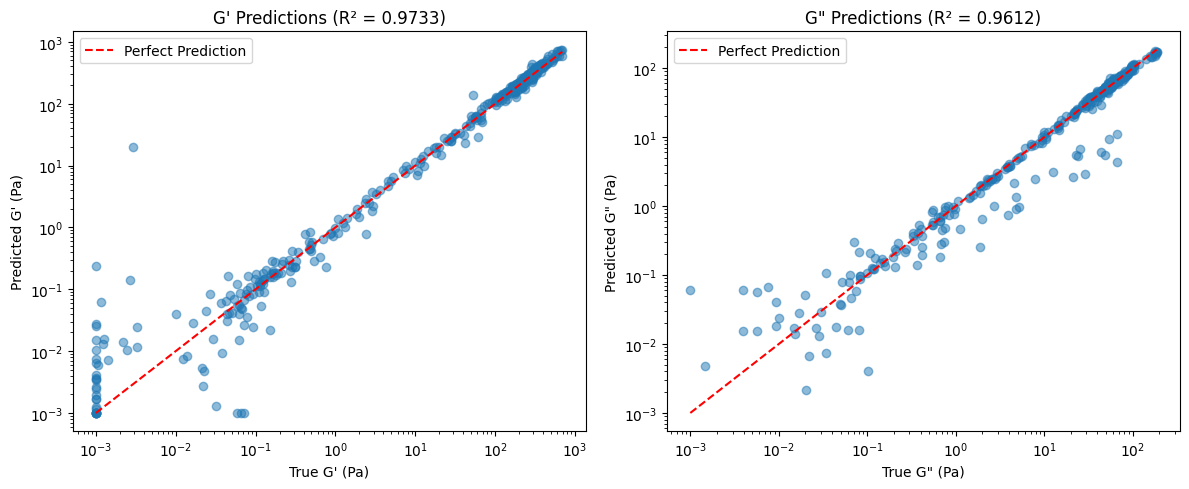

In [11]:
# Ê®°ÂûãËØÑ‰º∞ÂáΩÊï∞
def evaluate_model(model: RheologyPINN, dataset: RheologyDataset):
    """ËØÑ‰º∞Ê®°ÂûãÊÄßËÉΩ
    
    Args:
        model: ËÆ≠ÁªÉÂ•ΩÁöÑPINNÊ®°Âûã
        dataset: Êï∞ÊçÆÈõÜÂØπË±°
    """
    model.eval()
    with torch.no_grad():
        # Âú®È™åËØÅÈõÜ‰∏äËøõË°åÈ¢ÑÊµã
        y_pred = model(dataset.X_val)
        y_true = dataset.y_val
        
        
        # ÂèçÊ†áÂáÜÂåñÂà∞ÂØπÊï∞Á©∫Èó¥
        y_pred_cpu = y_pred.cpu().numpy()
        y_true_cpu = y_true.cpu().numpy()
        
        y_pred_log = dataset.scaler_y.inverse_transform(y_pred_cpu)
        y_true_log = dataset.scaler_y.inverse_transform(y_true_cpu)
        
        
        # üîß ÂÖ≥ÈîÆ‰øÆÂ§çÔºöË£ÅÂâ™ÂØπÊï∞Á©∫Èó¥ÁöÑÂÄºÔºåÈò≤Ê≠¢Ê∫¢Âá∫
        # float32ÁöÑÂÆâÂÖ®ËåÉÂõ¥Ôºö10^(-38) Âà∞ 10^38
        # ÂØπ‰∫éPaÂçï‰ΩçÁöÑÊ®°ÈáèÔºåÂêàÁêÜËåÉÂõ¥Á∫¶‰∏∫ 10^(-3) Âà∞ 10^10
        y_pred_log_clipped = np.clip(y_pred_log, -3, 10)
        y_true_log_clipped = np.clip(y_true_log, -3, 10)
        
        if not np.allclose(y_pred_log, y_pred_log_clipped):
            print("‚ö†Ô∏è Ë≠¶ÂëäÔºöÈÉ®ÂàÜÈ¢ÑÊµãÂÄºË∂ÖÂá∫ÂêàÁêÜËåÉÂõ¥ÔºåÂ∑≤ËøõË°åË£ÅÂâ™")
        
        # ËΩ¨Êç¢Âà∞Á∫øÊÄßÁ©∫Èó¥
        y_pred_orig = np.power(10.0, y_pred_log_clipped)
        y_true_orig = np.power(10.0, y_true_log_clipped)
        
        print(f"\ny_pred (Á∫øÊÄßÁ©∫Èó¥) ËåÉÂõ¥: [{y_pred_orig.min():.2e}, {y_pred_orig.max():.2e}] Pa")
        print(f"y_true (Á∫øÊÄßÁ©∫Èó¥) ËåÉÂõ¥: [{y_true_orig.min():.2e}, {y_true_orig.max():.2e}] Pa")
        
        # Ê£ÄÊü•ÊòØÂê¶ÊúâÊó†ÊïàÂÄº
        if np.any(~np.isfinite(y_pred_orig)) or np.any(~np.isfinite(y_true_orig)):
            print("\n‚ùå ÈîôËØØÔºö‰ªçÁÑ∂Â≠òÂú®Êó†ÊïàÂÄºÔºàinfÊàñnanÔºâ")
            print(f"   y_pred‰∏≠ÁöÑinf/nanÊï∞Èáè: {np.sum(~np.isfinite(y_pred_orig))}")
            print(f"   y_true‰∏≠ÁöÑinf/nanÊï∞Èáè: {np.sum(~np.isfinite(y_true_orig))}")
            return
        
        # ËÆ°ÁÆóR¬≤ÂàÜÊï∞
        from sklearn.metrics import r2_score
        r2_g1 = r2_score(y_true_orig[:, 0], y_pred_orig[:, 0])
        r2_g2 = r2_score(y_true_orig[:, 1], y_pred_orig[:, 1])
        
        
        # ÁªòÂà∂È¢ÑÊµãvsÂÆûÈôÖÂÄºÁöÑÊï£ÁÇπÂõæ
        plt.figure(figsize=(12, 5))
        
        plt.subplot(1, 2, 1)
        plt.scatter(y_true_orig[:, 0], y_pred_orig[:, 0], alpha=0.5)
        plt.plot([y_true_orig[:, 0].min(), y_true_orig[:, 0].max()],
                 [y_true_orig[:, 0].min(), y_true_orig[:, 0].max()],
                 'r--', label='Perfect Prediction')
        plt.xlabel('True G\' (Pa)')
        plt.ylabel('Predicted G\' (Pa)')
        plt.title(f'G\' Predictions (R¬≤ = {r2_g1:.4f})')
        plt.legend()
        plt.xscale('log')
        plt.yscale('log')
        
        plt.subplot(1, 2, 2)
        plt.scatter(y_true_orig[:, 1], y_pred_orig[:, 1], alpha=0.5)
        plt.plot([y_true_orig[:, 1].min(), y_true_orig[:, 1].max()],
                 [y_true_orig[:, 1].min(), y_true_orig[:, 1].max()],
                 'r--', label='Perfect Prediction')
        plt.xlabel('True G" (Pa)')
        plt.ylabel('Predicted G" (Pa)')
        plt.title(f'G" Predictions (R¬≤ = {r2_g2:.4f})')
        plt.legend()
        plt.xscale('log')
        plt.yscale('log')
        
        plt.tight_layout()
        plt.show()

# ËØÑ‰º∞Ê®°Âûã
evaluate_model(model, dataset)


In [12]:
# Áâ©ÁêÜ‰∏ÄËá¥ÊÄßÂêéÂ§ÑÁêÜÂáΩÊï∞
def apply_physics_constraints(df, dataset=None):
    """Â∫îÁî®ÂÆåÊï¥ÁöÑÁâ©ÁêÜÁ∫¶ÊùüÂà∞È¢ÑÊµãÁªìÊûú
    
    Args:
        df: ÂåÖÂê´È¢ÑÊµãÁªìÊûúÁöÑDataFrame
        dataset: Êï∞ÊçÆÈõÜÂØπË±°ÔºàÁî®‰∫éËé∑ÂèñÁ∫¶ÊùüÂèÇÊï∞ÔºåÁõÆÂâçÊú™‰ΩøÁî®Ôºâ
        
    Returns:
        Áâ©ÁêÜÁ∫¶ÊùüÂêéÁöÑDataFrame
    """
    import pandas as pd
    import numpy as np
    from scipy.ndimage import gaussian_filter1d
    
    # ÊåâÈ¢ëÁéáÊéíÂ∫è
    df = df.sort_values('Freq_rad_s').copy()
    
    # ËΩ¨Êç¢Âà∞ÂØπÊï∞Á©∫Èó¥ËøõË°åÊìç‰Ωú
    log_g1 = np.log10(df['G1_Pa_pred'].values + 1e-10)
    log_g2 = np.log10(df['G2_Pa_pred'].values + 1e-10)
    log_freq = np.log10(df['Freq_rad_s'].values)
    
    # 1. Â∫îÁî®ÊñúÁéáËåÉÂõ¥Á∫¶ÊùüÂíåÂπ≥ÊªëÊÄßÔºàÈ´òÊñØÊª§Ê≥¢ + ÊñúÁéáË£ÅÂâ™Ôºâ
    
    # ÂÖàÂπ≥ÊªëÔºàÂáèÂ∞ëÂô™Â£∞Ôºâ
    log_g1_smooth = gaussian_filter1d(log_g1, sigma=1.0, mode='nearest')
    log_g2_smooth = gaussian_filter1d(log_g2, sigma=1.0, mode='nearest')
    
    # ËÆ°ÁÆóÊñúÁéá
    for iteration in range(3):  # Ëø≠‰ª£‰øÆÊ≠£
        g1_grad = np.diff(log_g1_smooth)
        g2_grad = np.diff(log_g2_smooth)
        
        # Ë£ÅÂâ™ÊñúÁéáÂà∞ÂêàÁêÜËåÉÂõ¥ [-0.1, 0.4]
        g1_grad = np.clip(g1_grad, -0.1, 0.4)  # ÂÖÅËÆ∏ËΩªÂæÆ‰∏ãÈôçÔºåÂêåÊó∂ÈôêÂà∂ÊúÄÂ§ßÂ¢ûÈïø
        g2_grad = np.clip(g2_grad, -0.1, 0.4)
        
        # ‰ªéÊñúÁéáÈáçÂª∫Êõ≤Á∫ø
        log_g1_smooth[1:] = log_g1_smooth[0] + np.cumsum(g1_grad)
        log_g2_smooth[1:] = log_g2_smooth[0] + np.cumsum(g2_grad)
    
    # 2. Â∫îÁî®tan(Œ¥)Á∫¶ÊùüÔºàÂπ≥ÊªëÊñπÂºèÔºâ
    tan_delta = np.power(10, log_g2_smooth - log_g1_smooth)
    
    # Ê£ÄÊü•Âπ∂‰øÆÊ≠£Ë∂ÖÂá∫ËåÉÂõ¥ÁöÑtan(Œ¥)
    tan_delta = np.clip(tan_delta, 0, 10.0)  # ÂêàÁêÜËåÉÂõ¥
    
    # Âπ≥Êªëtan(Œ¥)Êõ≤Á∫ø
    log_tan_delta = np.log10(tan_delta)
    log_tan_delta_smooth = gaussian_filter1d(log_tan_delta, sigma=1.5, mode='nearest')
    tan_delta_smooth = np.power(10, log_tan_delta_smooth)
    
    # ‰ªéÂπ≥ÊªëÁöÑtan(Œ¥)ÂíåG'ÈáçÂª∫G"
    # ‰ΩøÁî®Âá†‰ΩïÂπ≥Âùá‰øùÊåÅËÉΩÈáèÂÆàÊÅí
    g_complex = np.sqrt(np.power(10, log_g1_smooth)**2 + np.power(10, log_g2_smooth)**2)
    g1_new = g_complex / np.sqrt(1 + tan_delta_smooth**2)
    g2_new = g1_new * tan_delta_smooth
    
    log_g1_final = np.log10(g1_new + 1e-10)
    log_g2_final = np.log10(g2_new + 1e-10)
    
    # 3. È´òÈ¢ëÂå∫ÂüüÁâπÊÆäÂ§ÑÁêÜÔºàÈôç‰ΩéÊñúÁéáÔºâ
    freq = df['Freq_rad_s'].values
    high_freq_mask = freq > 10.0
    if high_freq_mask.any():
        high_freq_indices = np.where(high_freq_mask)[0]
        if len(high_freq_indices) > 1:
            # Âú®È´òÈ¢ëÂå∫ÂüüÈ¢ùÂ§ñÂπ≥Êªë
            log_g1_final[high_freq_indices] = gaussian_filter1d(
                log_g1_final[high_freq_indices], sigma=1.5, mode='nearest'
            )
            log_g2_final[high_freq_indices] = gaussian_filter1d(
                log_g2_final[high_freq_indices], sigma=1.5, mode='nearest'
            )
    
    # 4. Á°Æ‰øùCox-MerzËßÑÂàôÔºàÂ§çÊï∞Á≤òÂ∫¶ÂçïË∞ÉÈÄíÂáèÔºâ
    log_complex_visc = np.log10(g_complex / freq + 1e-10)
    visc_grad = np.diff(log_complex_visc)
    
    # Â¶ÇÊûúÂ§çÊï∞Á≤òÂ∫¶Â¢ûÂä†ÔºåÁï•ÂæÆË∞ÉÊï¥G'ÂíåG"
    violation_mask = visc_grad > 0
    if violation_mask.any():
        for idx in np.where(violation_mask)[0]:
            if idx < len(log_g1_final) - 1:
                # ËΩªÂæÆÈôç‰ΩéËøùËßÑÁÇπÁöÑÊñúÁéá
                correction_factor = 0.95
                log_g1_final[idx+1] = log_g1_final[idx+1] * correction_factor + log_g1_final[idx] * (1 - correction_factor)
                log_g2_final[idx+1] = log_g2_final[idx+1] * correction_factor + log_g2_final[idx] * (1 - correction_factor)
    
    # 5. ÊúÄÁªàÁ°Æ‰øùÊñúÁéáÂú®ÂêàÁêÜËåÉÂõ¥ÂÜÖÔºàÂÖÅËÆ∏ËΩªÂæÆ‰∏ãÈôçÔºâ
    # ‰∏çÂÜçÂº∫Âà∂ÂçïË∞ÉÈÄíÂ¢ûÔºåÂõ†‰∏∫ÂÖÅËÆ∏ -0.1 ÁöÑË¥üÊñúÁéá
    for i in range(1, len(log_g1_final)):
        # Á°Æ‰øù‰∏ãÈôçÂπÖÂ∫¶‰∏çË∂ÖËøá -0.1ÔºàÂØπÊï∞Á©∫Èó¥Ôºâ
        if log_g1_final[i] < log_g1_final[i-1] - 0.1:
            log_g1_final[i] = log_g1_final[i-1] - 0.1
        if log_g2_final[i] < log_g2_final[i-1] - 0.1:
            log_g2_final[i] = log_g2_final[i-1] - 0.1
    
    # ËΩ¨Êç¢ÂõûÁ∫øÊÄßÁ©∫Èó¥
    df['G1_Pa_pred'] = np.power(10, log_g1_final)
    df['G2_Pa_pred'] = np.power(10, log_g2_final)
    df['tan_delta_pred'] = df['G2_Pa_pred'] / df['G1_Pa_pred']
    

    return df

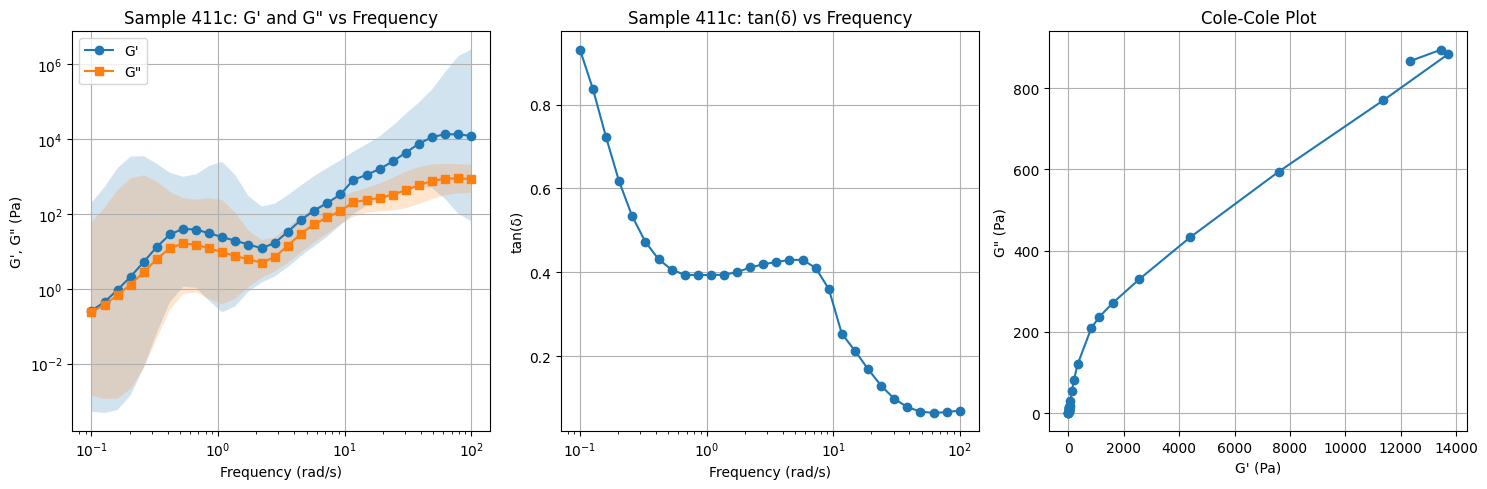


Êñ∞Ê†∑Êú¨È¢ÑÊµãÁªìÊûú:
   Sample_ID  Length_nm  Width_nm  Temp_C  Freq_rad_s    G1_Pa_pred  \
0       411c        300     20.94      25       0.100      0.259730   
1       411c        300     20.94      25       0.127      0.447071   
2       411c        300     20.94      25       0.161      0.946139   
3       411c        300     20.94      25       0.204      2.117783   
4       411c        300     20.94      25       0.259      5.267016   
5       411c        300     20.94      25       0.329     13.326139   
6       411c        300     20.94      25       0.418     28.713657   
7       411c        300     20.94      25       0.530     40.251968   
8       411c        300     20.94      25       0.672     38.454094   
9       411c        300     20.94      25       0.853     30.579054   
10      411c        300     20.94      25       1.080     24.289804   
11      411c        300     20.94      25       1.370     19.294077   
12      411c        300     20.94      25       1.740

In [13]:
# È¢ÑÊµãÊñ∞Ê†∑Êú¨ÁöÑÂáΩÊï∞
def predict_rheology(model: RheologyPINN, 
                    sample_data: pd.DataFrame, 
                    dataset: RheologyDataset,
                    with_uncertainty: bool = True) -> pd.DataFrame:
    """È¢ÑÊµãÊñ∞Ê†∑Êú¨ÁöÑÊµÅÂèòÊÄßËÉΩ
    
    Args:
        model: ËÆ≠ÁªÉÂ•ΩÁöÑPINNÊ®°Âûã
        sample_data: ÂåÖÂê´Êñ∞Ê†∑Êú¨Êï∞ÊçÆÁöÑDataFrame
        dataset: Êï∞ÊçÆÈõÜÂØπË±°
        with_uncertainty: ÊòØÂê¶ËÆ°ÁÆóÈ¢ÑÊµã‰∏çÁ°ÆÂÆöÊÄß
        
    Returns:
        È¢ÑÊµãÁªìÊûúDataFrame
    """
    # ÁâπÂæÅÂ∑•Á®ã
    processed_data = sample_data.copy()
    
    # Âü∫Êú¨ÁâπÂæÅÂ∑•Á®ã
    processed_data['aspect_ratio'] = processed_data['Length_nm'] / processed_data['Width_nm']
    processed_data['log_freq'] = np.log10(processed_data['Freq_rad_s'])
    
    # ÂàÜÂ≠êÈáèÁõ∏ÂÖ≥ÁâπÂæÅ
    if 'Mw' in processed_data.columns and 'Mn' in processed_data.columns:
        processed_data['PDI'] = processed_data['Mw'] / processed_data['Mn']
        processed_data['log_Mw'] = np.log10(processed_data['Mw'])
        processed_data['log_Mn'] = np.log10(processed_data['Mn'])
    else:
        processed_data['Mw'] = 0
        processed_data['Mn'] = 0
        processed_data['PDI'] = 1
        processed_data['log_Mw'] = 0
        processed_data['log_Mn'] = 0
    
    # ÊµìÂ∫¶ÁâπÂæÅ
    if 'c' in processed_data.columns:
        processed_data['log_c'] = np.log10(processed_data['c'])
    else:
        processed_data['c'] = 0
        processed_data['log_c'] = 0
    
    # WLFÊó∂Ê∏©Á≠âÊïàÊÄßÁâπÂæÅ
    T_ref = 25  # ÂèÇËÄÉÊ∏©Â∫¶
    C1 = 8.86   # WLFÂèÇÊï∞
    C2 = 101.6  # WLFÂèÇÊï∞
    processed_data['aT'] = 10 ** (-C1 * (processed_data['Temp_C'] - T_ref) / 
                                 (C2 + processed_data['Temp_C'] - T_ref))
    
    # Ê∏©Â∫¶Áõ∏ÂÖ≥ÁâπÂæÅ
    processed_data['temp_inv'] = 1 / (processed_data['Temp_C'] + 273.15)
    processed_data['T_x_aspect'] = processed_data['Temp_C'] * processed_data['aspect_ratio']
    
    # ÂáÜÂ§áËæìÂÖ•ÁâπÂæÅ
    X_new = dataset.scaler_X.transform(processed_data[dataset.feature_cols])
    X_new = torch.FloatTensor(X_new).to(device)
    
    # È¢ÑÊµã
    model.eval()
    if with_uncertainty:
        # ‰ΩøÁî®Monte Carlo DropoutËøõË°åÂ∏¶‰∏çÁ°ÆÂÆöÊÄßÁöÑÈ¢ÑÊµã
        mean_pred, std_pred = model.predict_with_uncertainty(X_new, MC_SAMPLES)
        y_pred = mean_pred
        
        # ‚ö†Ô∏è ÂÖ≥ÈîÆ‰øÆÂ§çÔºöÂú®ÂØπÊï∞Á©∫Èó¥Ê≠£Á°ÆËÆ°ÁÆóÁΩÆ‰ø°Âå∫Èó¥
        # ÂÖàÂèçÊ†áÂáÜÂåñÂà∞ÂØπÊï∞Á©∫Èó¥
        y_pred_cpu = y_pred.cpu().detach().numpy()
        std_pred_cpu = std_pred.cpu().detach().numpy()
        
        # ÂèçÊ†áÂáÜÂåñÔºàÂõûÂà∞ÂØπÊï∞Á©∫Èó¥Ôºâ
        y_log = dataset.scaler_y.inverse_transform(y_pred_cpu)
        
        # Âú®ÂØπÊï∞Á©∫Èó¥ËÆ°ÁÆóÁΩÆ‰ø°Âå∫Èó¥ÔºàÊ†áÂáÜÂ∑ÆÂú®Ê†áÂáÜÂåñÁ©∫Èó¥ÔºåÈúÄË¶ÅÁº©ÊîæÔºâ
        std_log = std_pred_cpu * dataset.scaler_y.scale_
        
        # ÂØπÊï∞Á©∫Èó¥ÁöÑÁΩÆ‰ø°Âå∫Èó¥
        y_log_upper = y_log + 2 * std_log  # 95% ÁΩÆ‰ø°Âå∫Èó¥
        y_log_lower = y_log - 2 * std_log
        
        # ËΩ¨Êç¢Âà∞Á∫øÊÄßÁ©∫Èó¥
        y_pred_orig = np.power(10.0, y_log)
        y_upper_orig = np.power(10.0, y_log_upper)
        y_lower_orig = np.power(10.0, y_log_lower)
        
        # Ê∑ªÂä†È¢ÑÊµãÁªìÊûúÂíå‰∏çÁ°ÆÂÆöÊÄß
        results = processed_data.copy()
        results['G1_Pa_pred'] = y_pred_orig[:, 0]
        results['G2_Pa_pred'] = y_pred_orig[:, 1]
        results['G1_Pa_lower'] = y_lower_orig[:, 0]
        results['G1_Pa_upper'] = y_upper_orig[:, 0]
        results['G2_Pa_lower'] = y_lower_orig[:, 1]
        results['G2_Pa_upper'] = y_upper_orig[:, 1]
    else:
        # ‰∏çËÆ°ÁÆó‰∏çÁ°ÆÂÆöÊÄßÁöÑÁÆÄÂçïÈ¢ÑÊµã
        with torch.no_grad():
            y_pred = model(X_new)
            y_pred_orig = dataset.inverse_transform_y(y_pred)
            
            results = processed_data.copy()
            results['G1_Pa_pred'] = y_pred_orig[:, 0]
            results['G2_Pa_pred'] = y_pred_orig[:, 1]
    
    # ËÆ°ÁÆóÂàùÂßãtan_delta
    results['tan_delta_pred'] = results['G2_Pa_pred'] / results['G1_Pa_pred']
    
    # ‚ö†Ô∏è ÂÖ≥ÈîÆ‰øÆÂ§çÔºöÂÖà‰øùÂ≠òÊú™‰øÆÊ≠£ÁöÑÈ¢ÑÊµãÂÄºÂíå‰∏çÁ°ÆÂÆöÊÄßÁöÑÊØî‰æãÂÖ≥Á≥ª
    if 'G1_Pa_lower' in results.columns:
        # Âú®ÂØπÊï∞Á©∫Èó¥ËÆ°ÁÆó‰∏çÁ°ÆÂÆöÊÄßÁöÑÁõ∏ÂØπÂÅèÂ∑Æ
        results['G1_log_uncertainty_lower'] = np.log10(results['G1_Pa_pred']) - np.log10(results['G1_Pa_lower'])
        results['G1_log_uncertainty_upper'] = np.log10(results['G1_Pa_upper']) - np.log10(results['G1_Pa_pred'])
        results['G2_log_uncertainty_lower'] = np.log10(results['G2_Pa_pred']) - np.log10(results['G2_Pa_lower'])
        results['G2_log_uncertainty_upper'] = np.log10(results['G2_Pa_upper']) - np.log10(results['G2_Pa_pred'])
    
    # Â∫îÁî®ÂÆåÊï¥ÁöÑÁâ©ÁêÜ‰∏ÄËá¥ÊÄßÂêéÂ§ÑÁêÜÔºàÊõøÊç¢ÂéüÊúâÁöÑÁÆÄÂçïË∞ÉÊï¥Ôºâ
    # ÂØπÊØè‰∏™Ê†∑Êú¨ÂàÜÂà´Â§ÑÁêÜ
    processed_results = []
    for sample_id in results['Sample_ID'].unique():
        sample_df = results[results['Sample_ID'] == sample_id].copy()
        sample_df = apply_physics_constraints(sample_df, dataset)
        processed_results.append(sample_df)
    
    results = pd.concat(processed_results, ignore_index=True)
    
    # Â¶ÇÊûúÊúâ‰∏çÁ°ÆÂÆöÊÄß‰º∞ËÆ°ÔºåÂü∫‰∫é‰øÆÊ≠£ÂêéÁöÑÈ¢ÑÊµãÂÄºÈáçÊñ∞ËÆ°ÁÆóËæπÁïå
    if 'G1_Pa_lower' in results.columns:
        # ‰ΩøÁî®‰øÆÊ≠£ÂêéÁöÑÈ¢ÑÊµãÂÄºÂíå‰πãÂâç‰øùÂ≠òÁöÑ‰∏çÁ°ÆÂÆöÊÄßÂÅèÂ∑ÆÈáçÊñ∞ËÆ°ÁÆóËæπÁïå
        # Âú®ÂØπÊï∞Á©∫Èó¥Êìç‰ΩúÔºå‰øùÊåÅÁõ∏ÂØπ‰∏çÁ°ÆÂÆöÊÄß
        log_g1_pred = np.log10(results['G1_Pa_pred'].values)
        log_g2_pred = np.log10(results['G2_Pa_pred'].values)
        
        # ÈáçÊñ∞Â∫îÁî®‰∏çÁ°ÆÂÆöÊÄßÂÅèÂ∑Æ
        log_g1_lower = log_g1_pred - results['G1_log_uncertainty_lower'].values
        log_g1_upper = log_g1_pred + results['G1_log_uncertainty_upper'].values
        log_g2_lower = log_g2_pred - results['G2_log_uncertainty_lower'].values
        log_g2_upper = log_g2_pred + results['G2_log_uncertainty_upper'].values
        
        # ÂØπ‰∏çÁ°ÆÂÆöÊÄßËæπÁïåËøõË°åÂπ≥ÊªëÂ§ÑÁêÜ
        from scipy.ndimage import gaussian_filter1d
        for sample_id in results['Sample_ID'].unique():
            mask = results['Sample_ID'] == sample_id
            indices = np.where(mask)[0]
            
            if len(indices) > 3:
                log_g1_lower[indices] = gaussian_filter1d(log_g1_lower[indices], sigma=1.0, mode='nearest')
                log_g1_upper[indices] = gaussian_filter1d(log_g1_upper[indices], sigma=1.0, mode='nearest')
                log_g2_lower[indices] = gaussian_filter1d(log_g2_lower[indices], sigma=1.0, mode='nearest')
                log_g2_upper[indices] = gaussian_filter1d(log_g2_upper[indices], sigma=1.0, mode='nearest')
        
        # ËΩ¨Êç¢ÂõûÁ∫øÊÄßÁ©∫Èó¥
        results['G1_Pa_lower'] = np.power(10, log_g1_lower)
        results['G1_Pa_upper'] = np.power(10, log_g1_upper)
        results['G2_Pa_lower'] = np.power(10, log_g2_lower)
        results['G2_Pa_upper'] = np.power(10, log_g2_upper)
        
        # Á°Æ‰øùËæπÁïåÂåÖÂê´È¢ÑÊµãÂÄºÔºàÊ∑ªÂä†ÂÆâÂÖ®ËæπË∑ùÔºâ
        results['G1_Pa_lower'] = np.minimum(results['G1_Pa_lower'], results['G1_Pa_pred'] * 0.95)
        results['G1_Pa_upper'] = np.maximum(results['G1_Pa_upper'], results['G1_Pa_pred'] * 1.05)
        results['G2_Pa_lower'] = np.minimum(results['G2_Pa_lower'], results['G2_Pa_pred'] * 0.95)
        results['G2_Pa_upper'] = np.maximum(results['G2_Pa_upper'], results['G2_Pa_pred'] * 1.05)
        
        # Âà†Èô§‰∏¥Êó∂Âàó
        results = results.drop(columns=['G1_log_uncertainty_lower', 'G1_log_uncertainty_upper',
                                       'G2_log_uncertainty_lower', 'G2_log_uncertainty_upper'])
    
    return results

# Á§∫‰æãÔºöÈ¢ÑÊµãÊñ∞Ê†∑Êú¨
new_samples = pd.DataFrame({
    "Sample_ID": ["411c"] * 30,
    "Length_nm": [300] * 30,
    "Width_nm": [20.94] * 30,
    "Temp_C": [25] * 30,
    "c": [0.06] * 30,
    "Mn": [12230000] * 30,
    "Mw": [12590000] * 30,
    "Freq_rad_s": [0.1, 0.127, 0.161, 0.204, 0.259, 0.329, 0.418, 0.530, 0.672, 0.853, 1.08, 1.37, 1.74, 2.21, 2.81, 3.56, 
                   4.52, 5.74, 7.28, 9.24, 11.7, 14.9, 18.9, 24, 30.4, 38.6, 48.9, 62.1, 78.8, 100]
})

predictions = predict_rheology(model, new_samples, dataset)

# ÂèØËßÜÂåñÈ¢ÑÊµãÁªìÊûú
def plot_predictions(predictions: pd.DataFrame, sample_id: str):
    """ÂèØËßÜÂåñÈ¢ÑÊµãÁªìÊûú
    
    Args:
        predictions: È¢ÑÊµãÁªìÊûúDataFrame
        sample_id: Ê†∑ÂìÅID
    """
    sample_data = predictions[predictions['Sample_ID'] == sample_id]
    
    plt.figure(figsize=(15, 5))
    
    # G' Âíå G" ÈöèÈ¢ëÁéáÁöÑÂèòÂåñ
    plt.subplot(1, 3, 1)
    plt.loglog(sample_data['Freq_rad_s'], sample_data['G1_Pa_pred'], 'o-', label="G'")
    plt.loglog(sample_data['Freq_rad_s'], sample_data['G2_Pa_pred'], 's-', label='G"')
    if 'G1_Pa_lower' in sample_data.columns:
        plt.fill_between(sample_data['Freq_rad_s'], 
                        sample_data['G1_Pa_lower'],
                        sample_data['G1_Pa_upper'],
                        alpha=0.2)
        plt.fill_between(sample_data['Freq_rad_s'],
                        sample_data['G2_Pa_lower'],
                        sample_data['G2_Pa_upper'],
                        alpha=0.2)
    plt.xlabel('Frequency (rad/s)')
    plt.ylabel('G\', G" (Pa)')
    plt.title(f'Sample {sample_id}: G\' and G" vs Frequency')
    plt.legend()
    plt.grid(True)
    
    # tan(Œ¥) ÈöèÈ¢ëÁéáÁöÑÂèòÂåñ
    plt.subplot(1, 3, 2)
    plt.semilogx(sample_data['Freq_rad_s'], sample_data['tan_delta_pred'], 'o-')
    plt.xlabel('Frequency (rad/s)')
    plt.ylabel('tan(Œ¥)')
    plt.title(f'Sample {sample_id}: tan(Œ¥) vs Frequency')
    plt.grid(True)
    
    # Cole-ColeÂõæ
    plt.subplot(1, 3, 3)
    plt.plot(sample_data['G1_Pa_pred'], sample_data['G2_Pa_pred'], 'o-')
    plt.xlabel('G\' (Pa)')
    plt.ylabel('G" (Pa)')
    plt.title('Cole-Cole Plot')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

# ‰∏∫ÊØè‰∏™Êñ∞Ê†∑Êú¨ÁªòÂà∂È¢ÑÊµãÁªìÊûú
for sample_id in predictions['Sample_ID'].unique():
    plot_predictions(predictions, sample_id)

# ÊâìÂç∞È¢ÑÊµãÁªìÊûú
print("\nÊñ∞Ê†∑Êú¨È¢ÑÊµãÁªìÊûú:")
print(predictions[['Sample_ID', 'Length_nm', 'Width_nm', 'Temp_C', 
                  'Freq_rad_s', 'G1_Pa_pred', 'G2_Pa_pred', 'tan_delta_pred']])